In [23]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import resnet50
from data_preparation import get_dataloaders
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from peft import LoraConfig, get_peft_model

In [24]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data
batch_size = 64
trainloader, testloader = get_dataloaders(batch_size)

# Model
class ResNet50Fingerprint(nn.Module):
    def __init__(self):
        super(ResNet50Fingerprint, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final classification layer
        self.fc = nn.Linear(2048, 1)  # Add a new classification layer for binary output

    def forward(self, x1, x2):
        f1 = self.resnet(x1)
        f2 = self.resnet(x2)
        # Compute absolute difference between features
        diff = torch.abs(f1 - f2)
        out = self.fc(diff)
        return out

model = ResNet50Fingerprint().to(device)

# Freeze all the parameters in the model
for param in model.parameters():
    param.requires_grad = False


# Apply LoRA using the PEFT library
config = LoraConfig(
    r=16,
    lora_alpha=16,
        target_modules=["resnet.layer4.0.conv1", "resnet.layer4.0.conv2", "resnet.layer4.0.conv3",
                    "resnet.layer4.1.conv1", "resnet.layer4.1.conv2", "resnet.layer4.1.conv3",
                    "resnet.layer4.2.conv1", "resnet.layer4.2.conv2", "resnet.layer4.2.conv3"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["fc"],
)
lora_model = get_peft_model(model, config)
lora_model.print_trainable_parameters()
_ = lora_model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(lora_model.parameters(), lr=0.001, momentum=0.9)
torch.cuda.empty_cache()

Number of same pairs: 27000
Number of different pairs: 300000
Number of balanced different pairs: 27000


C:\tools\Anaconda3\envs\LoRA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\tools\Anaconda3\envs\LoRA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


trainable params: 477,185 || all params: 23,987,266 || trainable%: 1.9893263367321645


Epoch 1/50, Accuracy : 65.56 %, Loss: 0.662, F1 Score: 0.672
TP: 3816, FP: 2126, TN: 3265, FN: 1593
Epoch 2/50, Accuracy : 66.92 %, Loss: 0.624, F1 Score: 0.667
TP: 3572, FP: 1736, TN: 3655, FN: 1837
Epoch 3/50, Accuracy : 68.25 %, Loss: 0.603, F1 Score: 0.715
TP: 4303, FP: 2323, TN: 3068, FN: 1106
Epoch 4/50, Accuracy : 68.49 %, Loss: 0.587, F1 Score: 0.677
TP: 3567, FP: 1561, TN: 3830, FN: 1842
Epoch 5/50, Accuracy : 69.14 %, Loss: 0.573, F1 Score: 0.687
TP: 3652, FP: 1576, TN: 3815, FN: 1757
Epoch 6/50, Accuracy : 70.52 %, Loss: 0.562, F1 Score: 0.717
TP: 4040, FP: 1815, TN: 3576, FN: 1369
Epoch 7/50, Accuracy : 71.48 %, Loss: 0.547, F1 Score: 0.720
TP: 3952, FP: 1623, TN: 3768, FN: 1457
Epoch 8/50, Accuracy : 72.70 %, Loss: 0.536, F1 Score: 0.740
TP: 4197, FP: 1736, TN: 3655, FN: 1212
Epoch 9/50, Accuracy : 72.92 %, Loss: 0.522, F1 Score: 0.751
TP: 4421, FP: 1937, TN: 3454, FN: 988
Epoch 10/50, Accuracy : 73.70 %, Loss: 0.511, F1 Score: 0.756
TP: 4390, FP: 1821, TN: 3570, FN: 1019


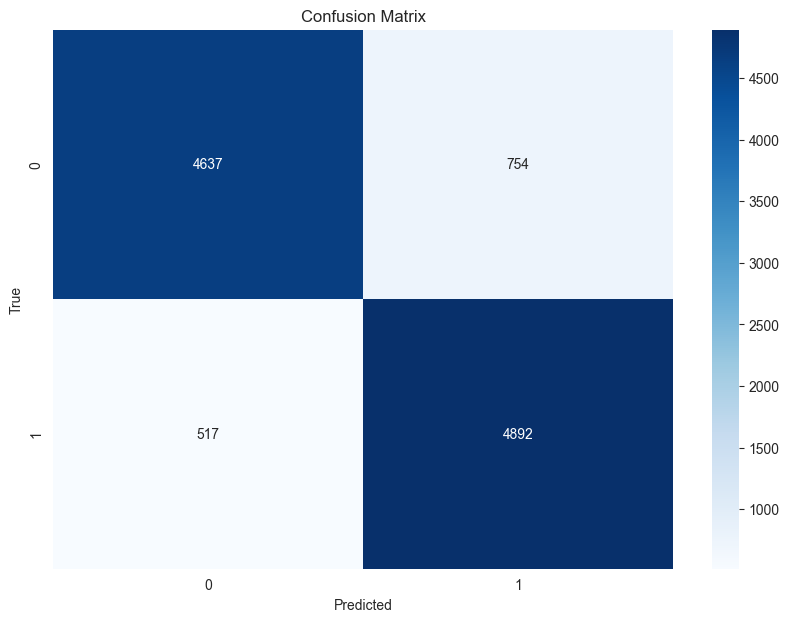

Finished Training


In [25]:
# Initialize TensorBoard
writer = SummaryWriter('runs/LoRA')

# Training The Model
epochs = 50
for epoch in range(epochs):
    lora_model.train()  # Set the model to training mode
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        (inputs1, inputs2), labels = data
        inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = lora_model(inputs1, inputs2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader)
    
    lora_model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data in testloader:
            (images1, images2), labels = data
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device).unsqueeze(1)
            outputs = lora_model(images1, images2)
            predictions = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    epoch_accuracy = 100 * correct / total
    epoch_f1 = f1_score(all_labels, all_predictions)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()

    # Log loss, accuracy, and F1 score for the epoch to TensorBoard
    writer.add_scalar('Accuracy/test', epoch_accuracy, epoch)
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('F1_Score/test', epoch_f1, epoch)
    
    print(f'Epoch {epoch+1}/{epochs}, Accuracy : {epoch_accuracy:.2f} %, Loss: {epoch_loss:.3f}, F1 Score: {epoch_f1:.3f}')
    print(f'TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')

# Visualize confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Finished Training')
writer.close()